# MIMIC Medical Notes NLP Entity Extraction and Visualization

This notebook demonstrates how to extract entities from MIMIC medical notes using spaCy, SciSpacy, Word2Vec, and t-SNE. It also shows how to access the MIMIC dataset using Google BigQuery and includes a bonus section with an additional clinical NLP tool. The workflow includes:

1. Accessing MIMIC data from BigQuery
2. Extracting entities with spaCy and SciSpacy
3. Training Word2Vec embeddings
4. Visualizing embeddings with t-SNE
5. Bonus: Applying an additional clinical NLP tool (e.g., ClinicalBERT)


In [2]:
# Install required libraries (uncomment if running for the first time)
#!pip install google-cloud-bigquery pandas spacy scispacy gensim scikit-learn matplotlib seaborn torch transformers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import spacy
import gensim
from sklearn.manifold import TSNE
import torch
from transformers import AutoTokenizer, AutoModel

print("All libraries imported.")

/opt/miniconda3/envs/mimic-vis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported.


## Accessing MIMIC Data from Google BigQuery
To access the MIMIC-III or MIMIC-IV dataset, you need to authenticate with Google Cloud and set up your BigQuery client. Make sure you have access to the MIMIC dataset in your Google Cloud project.

In [3]:
# Authenticate with Google Cloud (uncomment if running in Colab)
# from google.colab import auth
# auth.authenticate_user()
# Set up authentication and BigQuery client
import pydata_google_auth
import os
import yaml
# Define the scopes for Google Cloud authentication
from google.oauth2 import service_account 

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/bigquery'
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True
)

# Load configuration
config_path = os.path.join('.', 'config', 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Authenticate with Google Cloud
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True
)

# Initialize BigQuery client
client = bigquery.Client(
    project=config['bigquery']['project_id'],
    credentials=credentials
)

# Example: Query discharge summaries for patients with ICD9 code 430 (Subarachnoid hemorrhage)
query = '''
SELECT n.SUBJECT_ID, n.HADM_ID, n.CHARTTIME, n.note_type, n.TEXT
FROM `physionet-data.mimiciv_note.discharge` n
JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` d
  ON n.HADM_ID = d.HADM_ID
WHERE d.ICD_CODE = '4280'
  and d.icd_version = 9
  AND n.note_type = 'DS'
LIMIT 10
'''

notes_df = client.query(query).to_dataframe()
notes_df.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,note_type,TEXT
0,10122589,20296034,2180-09-10,DS,\nName: ___ Unit No: ___\n...
1,10150335,24113307,2144-09-17,DS,\nName: ___ Unit No: ___\n...
2,10160622,28904663,2176-01-19,DS,\nName: ___ Unit No: __...
3,10164170,24771340,2163-05-31,DS,\nName: ___ Unit No: __...
4,10172118,26968912,2124-04-24,DS,\nName: ___ Unit No: ___\...


## Entity Extraction with spaCy and SciSpacy
We will use both spaCy and SciSpacy to extract named entities from the medical notes. SciSpacy is specifically designed for biomedical and clinical text.

In [4]:
# Download spaCy and SciSpacy models if not already installed
# !python -m spacy download en_core_web_sm
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

import spacy
import scispacy

# Load spaCy and SciSpacy models
spacy_nlp = spacy.load('en_core_web_sm')
scispacy_nlp = spacy.load('en_core_sci_sm')

# Extract entities from the first note as an example
sample_text = notes_df['TEXT'].iloc[0]

spacy_doc = spacy_nlp(sample_text)
scispacy_doc = scispacy_nlp(sample_text)

print("spaCy Entities:")
print([(ent.text, ent.label_) for ent in spacy_doc.ents])

print("\nSciSpacy Entities:")
print([(ent.text, ent.label_) for ent in scispacy_doc.ents])

/opt/miniconda3/envs/mimic-vis/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


spaCy Entities:
[('Chief Complaint', 'PERSON'), ('O2', 'NORP'), ('95%', 'PERCENT'), ('6L', 'CARDINAL'), ('O2', 'CARDINAL'), ('102.3', 'CARDINAL'), ('ED', 'GPE'), ('CXR', 'ORG'), ('RLL', 'ORG'), ('UA', 'ORG'), ('SBP', 'ORG'), ('80', 'CARDINAL'), ('up to 100', 'CARDINAL'), ('1L', 'CARDINAL'), ('NS', 'GPE'), ('110', 'CARDINAL'), ('MICU', 'ORG'), ('DNR', 'ORG'), ('T99', 'PRODUCT'), ('O2 94%', 'PERCENT'), ('10L.', 'DATE'), ('CHF', 'ORG'), ('Family History', 'PERSON'), ('ADMISSION', 'ORG'), ('General-', 'GPE'), ('Elderly', 'GPE'), ('CV-', 'PERSON'), ('Tachycardic', 'PERSON'), ('Voluntary', 'PERSON'), ('TTP', 'ORG'), ('Neuro', 'PERSON'), ('MAE', 'ORG'), ('DISCHARGE', 'ORG'), ('Pertinent Results', 'PERSON'), ('BLOOD WBC-7.0', 'ORG'), ('PTT-28.5', 'PERSON'), ('# \nNa-149', 'ORG'), ('29', 'CARDINAL'), ('AnGap-17', 'NORP'), ('02:21AM BLOOD', 'PERSON'), ('06:45PM', 'PRODUCT'), ('12:55AM', 'CARDINAL'), ('06:50PM', 'PERSON'), ('pO2-35', 'ORG'), ('calTCO2-34', 'DATE'), ('06:50PM', 'PERSON'), ('CHF', 

## Word2Vec Embeddings and t-SNE Visualization
We will train a Word2Vec model on the medical notes and use t-SNE to visualize the embeddings of the extracted entities.

Using t-SNE perplexity=30 for 100 samples.


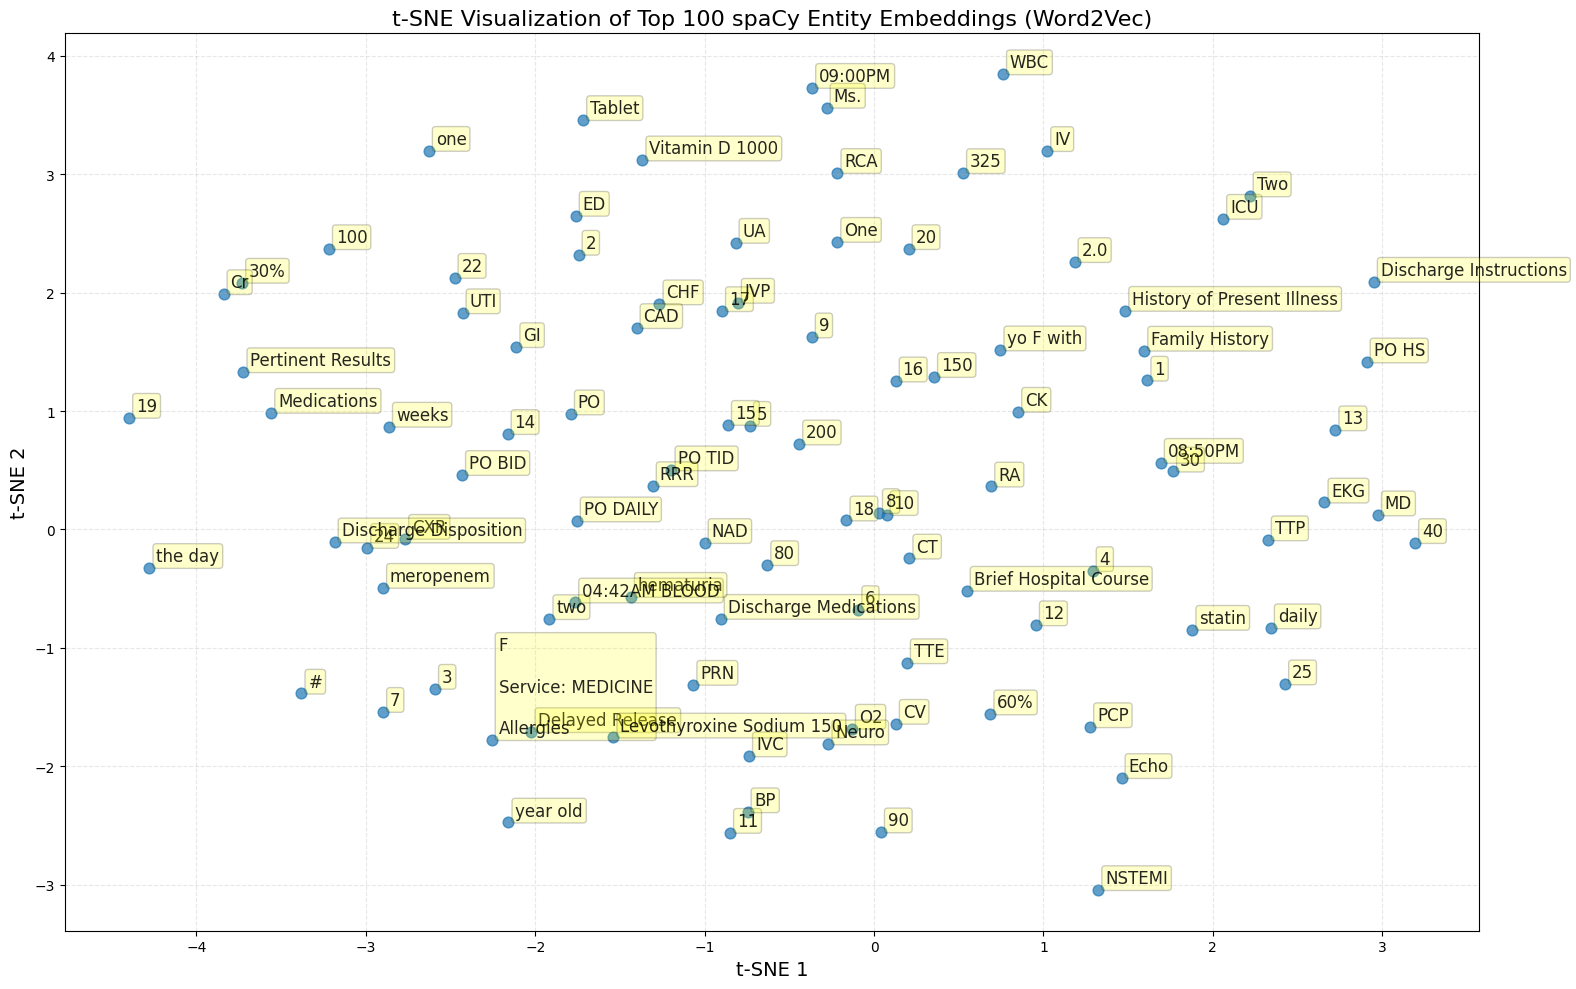

Using t-SNE perplexity=30 for 100 samples.


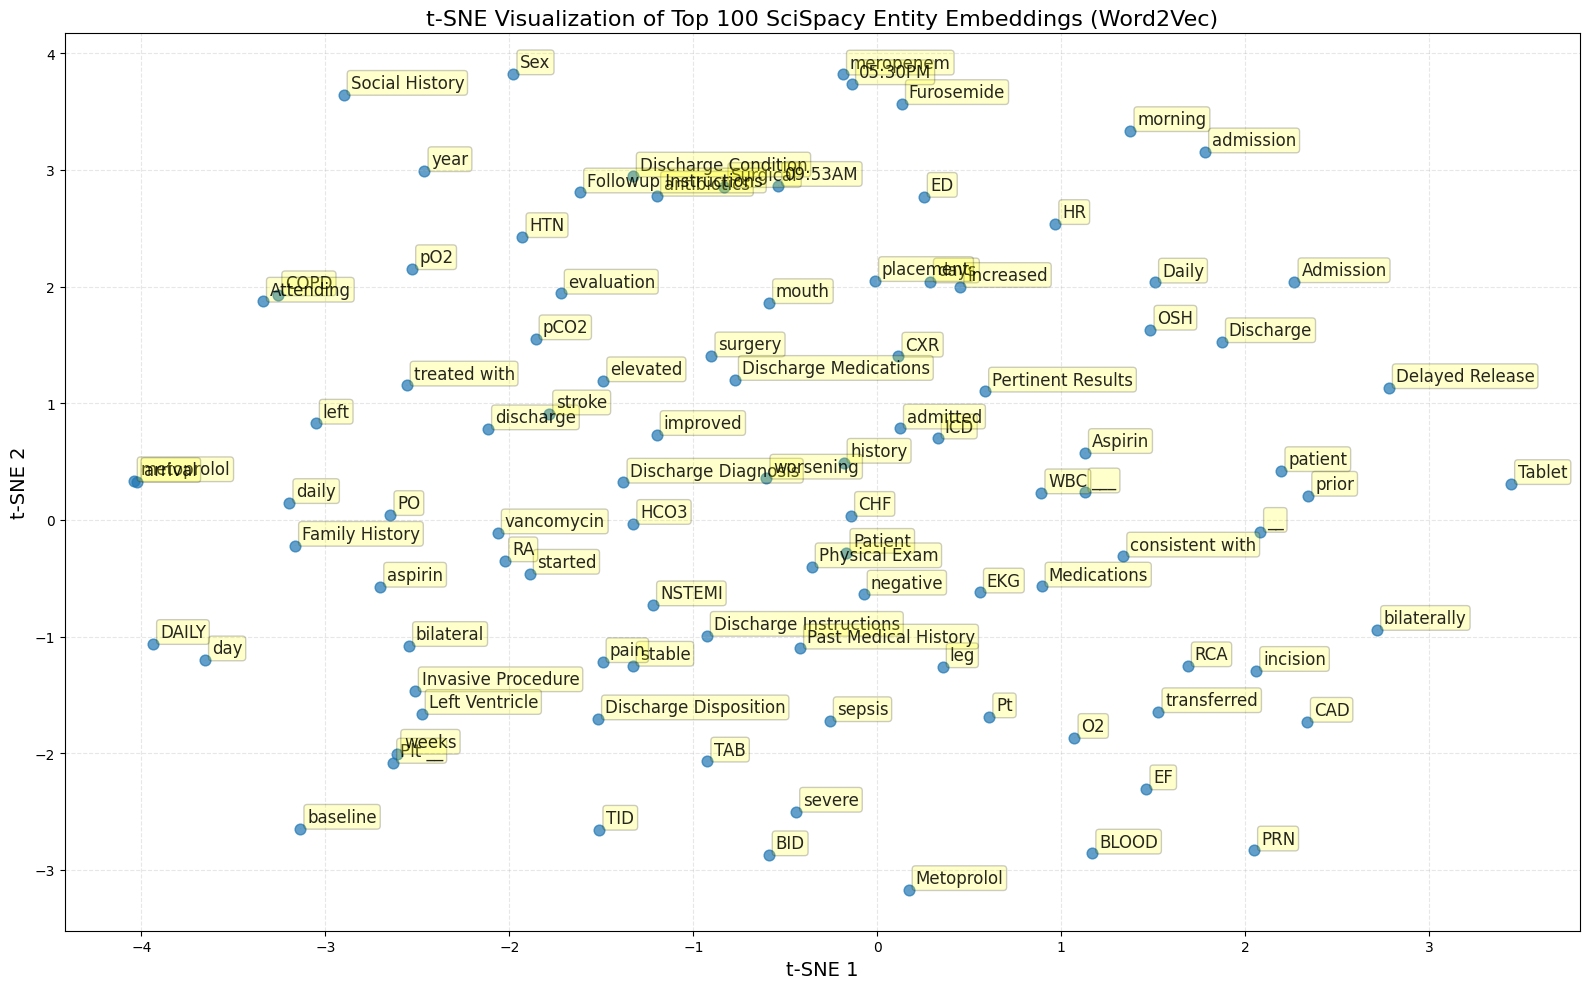

In [19]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Build corpus of entities for spaCy and SciSpacy separately
spacy_corpus = []
scispacy_corpus = []
for text in notes_df['TEXT']:
    spacy_doc = spacy_nlp(text)
    scispacy_doc = scispacy_nlp(text)
    spacy_corpus.append([ent.text for ent in spacy_doc.ents])
    scispacy_corpus.append([ent.text for ent in scispacy_doc.ents])

# Train Word2Vec models for each corpus
w2v_spacy = Word2Vec(spacy_corpus, window=5, min_count=1, workers=4)
w2v_scispacy = Word2Vec(scispacy_corpus, window=5, min_count=1, workers=4)

# Prepare vocabulary for t-SNE (filter out empty strings)
spacy_vocab = [word for word in w2v_spacy.wv.index_to_key if word.strip()]
scispacy_vocab = [word for word in w2v_scispacy.wv.index_to_key if word.strip()]

# Improve readability: plot only the top N most frequent entities
N = 100  # Adjust N as needed
spacy_entity_counts = Counter([ent for doc in spacy_corpus for ent in doc if ent.strip()])
spacy_top_entities = [word for word, _ in spacy_entity_counts.most_common(N) if word in spacy_vocab]
scispacy_entity_counts = Counter([ent for doc in scispacy_corpus for ent in doc if ent.strip()])
scispacy_top_entities = [word for word, _ in scispacy_entity_counts.most_common(N) if word in scispacy_vocab]

# Function for t-SNE plot with improved readability
def tsne_plot(model, words, title):
    tokens = [model.wv[word] for word in words]
    labels = words
    n_samples = len(tokens)
    perplexity = min(30, max(2, n_samples // 3))
    print(f"Using t-SNE perplexity={perplexity} for {n_samples} samples.")
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))
    x = new_values[:, 0]
    y = new_values[:, 1]
    plt.figure(figsize=(16, 10))
    plt.scatter(x, y, s=60, alpha=0.7)
    # Use offset for labels to reduce overlap
    for i, label in enumerate(labels):
        plt.annotate(label, (x[i], y[i]), fontsize=12, alpha=0.85, xytext=(5,2), textcoords='offset points', ha='left', va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.2), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.3))
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE 1', fontsize=14)
    plt.ylabel('t-SNE 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot t-SNE for spaCy entities (top N most frequent)
if len(spacy_top_entities) > 1:
    tsne_plot(w2v_spacy, spacy_top_entities, f't-SNE Visualization of Top {N} spaCy Entity Embeddings (Word2Vec)')
else:
    print('Not enough spaCy entities for t-SNE plot.')

# Plot t-SNE for SciSpacy entities (top N most frequent)
if len(scispacy_top_entities) > 1:
    tsne_plot(w2v_scispacy, scispacy_top_entities, f't-SNE Visualization of Top {N} SciSpacy Entity Embeddings (Word2Vec)')
else:
    print('Not enough SciSpacy entities for t-SNE plot.')

## Bonus: Using ClinicalBERT for Medical Text Embeddings
As a bonus, we will use ClinicalBERT, a transformer-based model pre-trained on clinical notes, to generate embeddings for medical entities and visualize them with t-SNE.

Using t-SNE perplexity=16 for 50 samples.


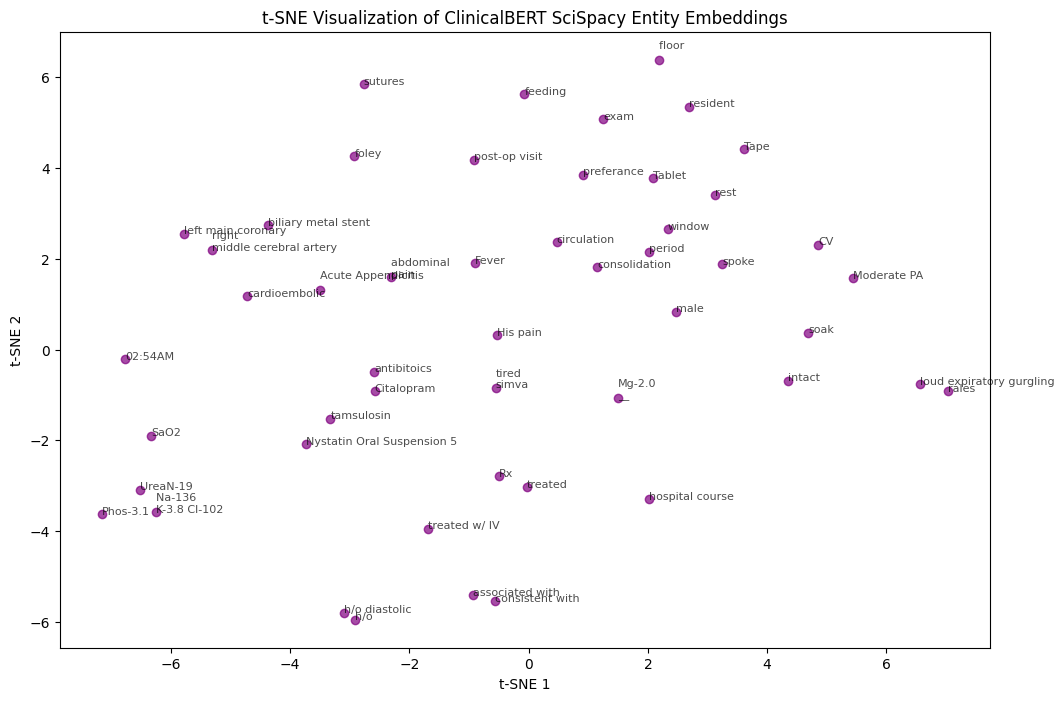

In [15]:
# Load ClinicalBERT model and tokenizer
model_name = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embedding for a phrase/entity (using [CLS] token)
import torch

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0, 0, :].numpy()


# Collect unique entities from SciSpacy only
scispacy_entities = set()
for text in notes_df['TEXT']:
    scispacy_doc = scispacy_nlp(text)
    scispacy_entities.update([ent.text for ent in scispacy_doc.ents if len(ent.text.strip()) > 1])

# Use only SciSpacy entities
entity_samples = list(scispacy_entities)[:50]

if len(entity_samples) < 3:
    print(f"Not enough SciSpacy entities for t-SNE plot (found {len(entity_samples)}). Try extracting more entities.")
else:
    entity_embeddings = np.array([get_bert_embedding(entity) for entity in entity_samples])
    # t-SNE with dynamic perplexity
    n_samples_bert = len(entity_embeddings)
    perplexity_bert = min(30, max(2, n_samples_bert // 3))
    print(f"Using t-SNE perplexity={perplexity_bert} for {n_samples_bert} samples.")
    tsne_bert = TSNE(n_components=2, random_state=42, perplexity=perplexity_bert)
    entity_tsne_bert = tsne_bert.fit_transform(entity_embeddings)
    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(entity_tsne_bert[:, 0], entity_tsne_bert[:, 1], alpha=0.7, color='purple')
    for i, entity in enumerate(entity_samples):
        plt.annotate(entity, (entity_tsne_bert[i, 0], entity_tsne_bert[i, 1]), fontsize=8, alpha=0.7)
    plt.title('t-SNE Visualization of ClinicalBERT SciSpacy Entity Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

In [11]:
# Print the first note used for embedding and visualization
if note_samples:
    print('Example clinical note:')
    print('-' * 60)
    print(note_samples[0])
    print('-' * 60)
else:
    print('No clinical notes available to print.')

Example clinical note:
------------------------------------------------------------
 
Name:  ___                 Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: MEDICINE
 
Allergies: 
Atenolol
 
Attending: ___
 
Chief Complaint:
Respiratory distress
 
Major Surgical or Invasive Procedure:
None
 
History of Present Illness:
___ with a history of COPD on 6L home O2 and prior respiratory 
failure, IDDM, and dementia who was recently d/c'd from the ED 
with a humeral fracture who now presents from nursing home with 
___ and respiratory distress.  In the ED he was AOx2, thought to 
be mentating below baseline. On exam had diffuse rhonci, was 
satting 95% on 6L (baseline home O2). Fever to 102.3 in ED, CXR 
showed a RLL infiltrate and effusion, and UA was positive so he 
was given vancomycin, ceftriaxone, and azithromycin. SBP dipped 
to 80's briefly and went back up to 100's after 1L NS, HR 
remained in 110's.  R

In [11]:
# Ensure spaCy model is installed
import spacy
try:
    spacy.load('en_core_web_sm')
except OSError:
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    print("Downloaded 'en_core_web_sm' model.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.8 MB ? eta -:--:--  Downloading https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.5 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Downloaded 'en_core_web_sm' model.
Downloaded 'en_core_web_sm' model.
